Repo prep

In [4]:
!git clone https://github.com/the-white-ghost/Retinaface_tf.git
%cd Retinaface_tf/

fatal: destination path 'Retinaface_tf' already exists and is not an empty directory.
/content/Retinaface_tf


In [5]:
!mkdir ./data/widerface;mkdir ./data/widerface/train/;mkdir ./data/widerface/val/ 

In [6]:
!unzip /content/drive/My*Drive/widerface/WIDER_train.zip && mv ./WIDER_train/images/ ./data/widerface/train; unzip /content/drive/My*Drive/widerface/WIDER_val.zip && mv ./WIDER_val/images/ ./data/widerface/val

Streaming output truncated to the last 5000 lines.
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_473.jpg  
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_474.jpg  
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_476.jpg  
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_478.jpg  
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_480.jpg  
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_49.jpg  
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_491.jpg  
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_494.jpg  
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sport

In [7]:
!cp /content/drive/My*Drive/widerface/train/label.txt ./data/widerface/train/; cp /content/drive/My*Drive/widerface/val/label.txt ./data/widerface/val/

In [8]:
!cp -r /content/drive/My*Drive/checkpoints ./

In [ ]:
!mkdir saved_model

In [9]:
!python ./data/convert_train_tfrecord.py --output_path="./data/widerface_train_bin.tfrecord" --is_binary=True

2020-10-02 09:11:28.728438: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
I1002 09:11:30.074914 140336946632576 convert_train_tfrecord.py:132] Loading ./data/widerface/train
I1002 09:11:30.075079 140336946632576 convert_train_tfrecord.py:134] Reading data list...
I1002 09:11:31.166183 140336946632576 convert_train_tfrecord.py:144] Writing 12880 sample to tfrecord file...
  0% 0/12880 [00:00<?, ?it/s]2020-10-02 09:11:31.178998: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-10-02 09:11:31.241730: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-02 09:11:31.242403: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeC

cp to drive, ls and rm -r (commands for ease of access...do not run)

In [ ]:
!ls /content/retinaface-tf2/saved_model/assets

In [ ]:
!cp -r /content/retinaface-tf2/frozen_model /content/drive/My*Drive

In [ ]:
!rm -r /content/retinaface-tf2/checkpoints/

In [ ]:
!rm -r /content/retinaface-tf2

add save model in train.py
[    tf.saved_model.save(model, './frozen_model')    ]

In [ ]:
!python train.py --gpu=1

###AddLayer

In [10]:
from modules.models import RetinaFaceModel
from modules.utils import (set_memory_growth, load_yaml, draw_bbox_landm, pad_input_image, recover_pad_output)
import tensorflow as tf
import os
from tensorflow.keras import Model
from tensorflow import keras

In [11]:
cfg_path = './configs/retinaface_mbv2.yaml'
cfg = load_yaml(cfg_path)
iou_th = 0.4
score_th =0.5

In [12]:
from modules.anchor import decode_tf, prior_box_tf
import modules.models as mm

In [13]:
input_size = None
wd = cfg['weights_decay']
out_ch = cfg['out_channel']
num_anchor = len(cfg['min_sizes'][0])
backbone_type = cfg['backbone_type']

In [14]:
x = inputs = keras.Input([input_size, input_size, 3], name='input_image')

In [15]:
x = mm.Backbone(backbone_type=backbone_type)(x)

9412608/9406464 [==============================] - 0s 0us/step


In [16]:
fpn = mm.FPN(out_ch=out_ch, wd=wd)(x)

In [17]:
features = [mm.SSH(out_ch=out_ch, wd=wd, name=f'SSH_{i}')(f)
                for i, f in enumerate(fpn)]

In [18]:
bbox_regressions = tf.concat(
        [mm.BboxHead(num_anchor, wd=wd, name=f'BboxHead_{i}')(f)
         for i, f in enumerate(features)], axis=1)

In [19]:
landm_regressions = tf.concat(
        [mm.LandmarkHead(num_anchor, wd=wd, name=f'LandmarkHead_{i}')(f)
         for i, f in enumerate(features)], axis=1)

In [20]:
classifications = tf.concat(
        [mm.ClassHead(num_anchor, wd=wd, name=f'ClassHead_{i}')(f)
         for i, f in enumerate(features)], axis=1)

In [21]:
classifications = tf.keras.layers.Softmax(axis=-1)(classifications)

In [22]:
preds = tf.concat(
    [bbox_regressions[0], landm_regressions[0],
    tf.ones_like(classifications[0, :, 0][..., tf.newaxis]),
    classifications[0, :, 1][..., tf.newaxis]], 1)
priors = prior_box_tf((tf.shape(inputs)[1], tf.shape(inputs)[2]),cfg['min_sizes'],  cfg['steps'], cfg['clip'])
decode_preds = decode_tf(preds, priors, cfg['variances'])

selected_indices = tf.image.non_max_suppression(
    boxes=decode_preds[:, :4],
    scores=decode_preds[:, -1],
    max_output_size=tf.shape(decode_preds)[0],
    iou_threshold=iou_th,
    score_threshold=score_th)

out = tf.gather(decode_preds, selected_indices)

In [23]:
def RFM(name='RetinaFaceModelModified'):
  return Model(inputs,out,name=name)

In [24]:
model = RFM()

In [25]:
model.summary()

Model: "RetinaFaceModelModified"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, None, None,  0                                            
__________________________________________________________________________________________________
tf_op_layer_Shape_1 (TensorFlow [(4,)]               0           input_image[0][0]                
__________________________________________________________________________________________________
tf_op_layer_Shape_2 (TensorFlow [(4,)]               0           input_image[0][0]                
__________________________________________________________________________________________________
tf_op_layer_strided_slice_6 (Te [()]                 0           tf_op_layer_Shape_1[0][0]        
____________________________________________________________________________

In [26]:
checkpoint_dir = './checkpoints/' + cfg['sub_name']
checkpoint = tf.train.Checkpoint(model=model)

In [27]:
if tf.train.latest_checkpoint(checkpoint_dir):
  checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
  print("[*] load ckpt from {}.".format(tf.train.latest_checkpoint(checkpoint_dir)))


Two checkpoint references resolved to different objects (<tensorflow.python.keras.engine.functional.Functional object at 0x7f42633031d0> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f425fe5bcc0>).

Two checkpoint references resolved to different objects (<modules.models.FPN object at 0x7f42633bd940> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f42620575f8>).

Two checkpoint references resolved to different objects (<modules.models.SSH object at 0x7f42622a6fd0> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f425fe72a20>).

Two checkpoint references resolved to different objects (<modules.models.SSH object at 0x7f4262156da0> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f425fe721d0>).

Two checkpoint references resolved to different objects (<modules.models.SSH object at 0x7f42621aa4e0> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at

In [32]:
import cv2 
from modules.utils import (set_memory_growth, load_yaml, draw_bbox_landm, pad_input_image, recover_pad_output)
import numpy as np
img = cv2.imread('/content/out_0_Parade_marchingband_1_149.jpg')
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img, pad_params = pad_input_image(img, max_steps=max(cfg['steps']))
outputs = model(img[np.newaxis, ...]).numpy()

In [33]:
bbox_regressions = outputs[0]
landm_regressions = outputs[1]
classifications = outputs[2]

In [34]:
outputs

array([[0.6979913 , 0.5564167 , 0.72268134, 0.6016033 , 0.7050968 ,
        0.57253546, 0.71651554, 0.5709184 , 0.71153367, 0.58042216,
        0.70720905, 0.58944046, 0.7168141 , 0.58788925, 1.        ,
        0.99806625],
       [0.6184861 , 0.5397502 , 0.641262  , 0.58237267, 0.6250368 ,
        0.5531733 , 0.6355469 , 0.55310625, 0.6301133 , 0.5609269 ,
        0.6257119 , 0.56942713, 0.6343533 , 0.5694029 , 1.        ,
        0.9901273 ],
       [0.43431142, 0.53642976, 0.4599426 , 0.5842656 , 0.43961564,
        0.5524747 , 0.4514581 , 0.55386513, 0.44326228, 0.5631752 ,
        0.43954423, 0.571027  , 0.44916564, 0.5711991 , 1.        ,
        0.98500526],
       [0.5173006 , 0.54984885, 0.54112494, 0.59369034, 0.5224833 ,
        0.5649794 , 0.5343028 , 0.5648481 , 0.5280751 , 0.5733027 ,
        0.52370054, 0.58137614, 0.53294027, 0.58107203, 1.        ,
        0.97882473],
       [0.65588796, 0.4522339 , 0.68049335, 0.4949578 , 0.6624618 ,
        0.46717232, 0.6736451 , 

In [35]:
outputs = recover_pad_output(outputs, pad_params)

In [36]:
for prior_index in range(len(outputs)):
  draw_bbox_landm(img, outputs[prior_index], img.shape[0],img.shape[1])

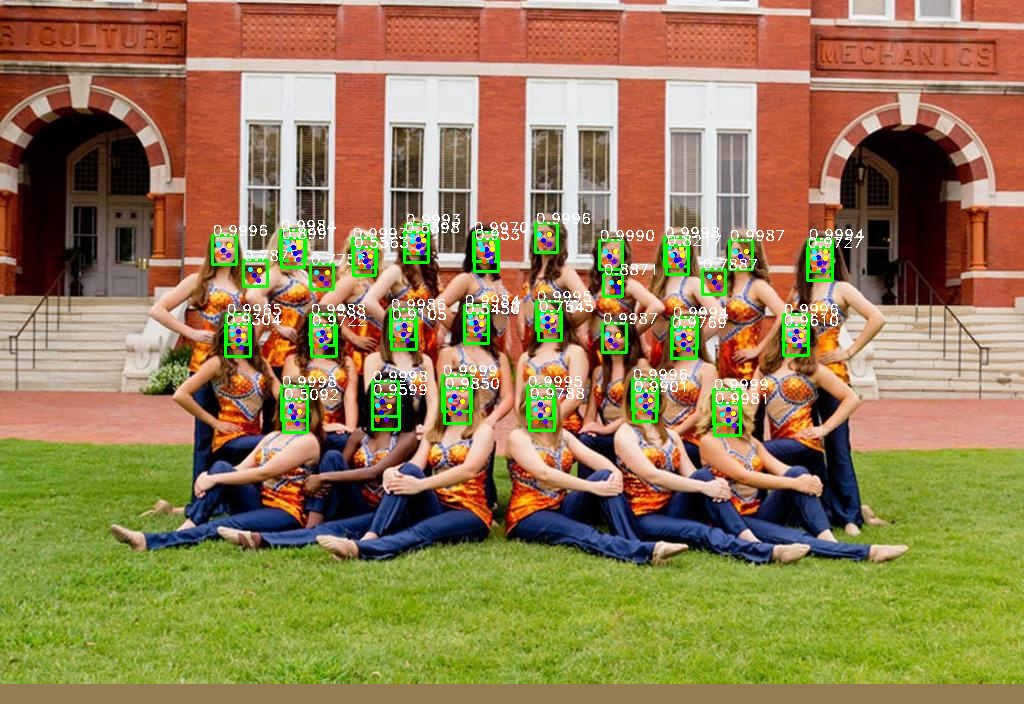

In [37]:
from google.colab.patches import cv2_imshow
cv2_imshow(img)

In [ ]:
 tf.saved_model.save(model, './frozen_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./frozen_model/assets


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter = True
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmps34rjpyb/assets


In [ ]:
!pip install tensorflow-gpu==2.1

     |████████████████████████████████| 421.8MB 28kB/s 
     |████████████████████████████████| 3.9MB 38.2MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
     |████████████████████████████████| 450kB 40.0MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=d85124e211af3ba6215074372e0a1a66e984e349a64354015ede96cd2a536e43
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.3.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorflow-estimator<2.4.0,>=2.3.0, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing ins

In [ ]:
import tensorflow
tensorflow.__version__

'2.1.0'

In [ ]:
!tflite_convert --output_file=./model_graph_try.tflite --graph_def_file=/content/retinaface-tf2/frozen_model/saved_model.pb --saved_model_dir=/content/retinaface-tf2/frozen_model

2020-08-17 10:21:20.914029: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-08-17 10:21:20.917322: E tensorflow/stream_executor/cuda/cuda_driver.cc:351] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-08-17 10:21:20.917369: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bd52508dc69d): /proc/driver/nvidia/version does not exist
2020-08-17 10:21:21.007318: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200000000 Hz
2020-08-17 10:21:21.007718: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x563c43512a80 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-08-17 10:21:21.007763: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
Traceback (most recent call last):
  File "/usr/local/bin